In [25]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import h5py, bisect, heapq
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, KFold
from scipy.stats import iqr
import random
random.seed(32815)
np.random.seed(32815)

In [2]:
with h5py.File('digits.h5')as f:
    images = f['images'].value
    labels = f['labels'].value

images = images/np.max(images)
print(images.shape)

(120000, 9, 9)


# 1. Data Generation with Naive Bayes

Using Histogram and NaiveBayesClassifier classes provided on Moodle

In [3]:
class Histogram(object):
    """Histogram.
    """

    def __init__(self, values):
        """Create a histogram for the given values using the Freedman-Diaconis rule for the bin width.

        :param values: the values from which the histogram will be computed
        """
        self.num_instances = len(values)

        # Get the number of bins.
        v_min, v_25, v_75, v_max = np.percentile(values, [0, 25, 75, 100])
        # freedman_diaconis_width = 2 * (v_75 - v_25) / (len(values) ** (1/3.0))
        freedman_diaconis_width = (v_max - v_min) / (len(values) ** (1/3.0))
        num_bins = int(round((v_max - v_min) / freedman_diaconis_width))
        assert num_bins > 0

        # Fill the bins.
        self.heights, self.bin_edges = np.histogram(values, bins=num_bins)
        # Normalize bins based on number of instances
        self.probs = self.heights / self.num_instances
        
    def find_bin(self, value):
        """Find the bin index of the given value.

        :param value: some value
        :return: bin index
        """
        bin_index = bisect.bisect_left(self.bin_edges, value) - 1
        bin_index = max(bin_index, 0)
        bin_index = min(bin_index, len(self.heights)-1)
        return bin_index

    def bin_probability(self, bin_index):
        """Return the bin probability of the desired bin.

        :param bin_index: index of the bin
        :return: probability of the bin
        """
        assert 0 <= bin_index <= len(self.heights) - 1
        return self.heights[bin_index] / float(self.num_instances)



class NaiveBayesClassifier(object):
    """Naive Bayes classifier.
    """

    def __init__(self):
        self.num_instances = None  # Number of instances that were used in training.
        self.num_feats = None  # Number of features that were used in training.
        self.classes = None  # The classes that were found in training.
        self.histograms = {}  # Dict with histograms, key: class, value: list with histograms for all features.
        self.priors = {}  # Dict with priors, key: class, value: prior of the class.

    def train(self, train_x, train_y):
        """Train the classifier.

        :param train_x: training x data
        :param train_y: training y data
        """
        assert train_x.shape[0] == len(train_y)
        self.num_instances = train_x.shape[0]
        self.num_feats = train_x.shape[1]
        self.classes = np.unique(train_y)

        # Create one histogram for each class and each feature.
        self.histograms.clear()
        self.priors.clear()
        for cl in self.classes:
            # Get the data of the current class.
            train_x_cl = [train_x[k] for k in range(self.num_instances) if train_y[k] == cl]
            num_instances_cl = len(train_x_cl)
            self.priors[cl] = num_instances_cl / float(self.num_instances)

            # Create one histogram per feature.
            self.histograms[cl] = []
            for i in range(self.num_feats):
                histo_points = [train_x_cl[k][i] for k in range(num_instances_cl)]
                self.histograms[cl].append(Histogram(histo_points))

    def probabilities_single(self, test_x):
        """Compute the class probabilities of a single instance.

        :param test_x: test x data of a single instance
        :return: probabilities of test_x for each class
        """
        assert len(test_x) == self.num_feats,\
            "NaiveBayesClassifier.probabilities_single(): Number of features in test and training must be the same."

        probs = {}
        for cl in self.classes:
            # Compute the likelihood.
            prob = self.priors[cl]
            for i in range(self.num_feats):
                # Find height of histogram bin with class cl that contains test_x[i].
                histo = self.histograms[cl][i]
                bin_index = histo.find_bin(test_x[i])
                prob *= histo.bin_probability(bin_index)
            probs[cl] = prob
        return probs

    def predict_single(self, test_x):
        """Predict the class of a single instance.

        :param test_x: test x data of a single instance
        :return: predicted class of test_x
        """
        probs = self.probabilities_single(test_x)
        max_cl = max(probs.keys(), key=lambda cl: probs[cl])
        return max_cl

    def predict(self, test_x):
        """Predict the classes of the given sample.

        :param test_x: test x data
        :return: predicted classes of test_x
        """
        assert test_x.shape[1] == self.num_feats,\
            "NaiveBayesClassifier.predict(): Number of features in test and training must be the same."
        return np.array([self.predict_single(test_x[i]) for i in range(test_x.shape[0])])

Choose digit for generation:

In [17]:
digit = 6

In [18]:
mask = labels == digit
x = images[mask]
x = x.reshape(x.shape[0], x.shape[1] * x.shape[2])
y = labels[mask]

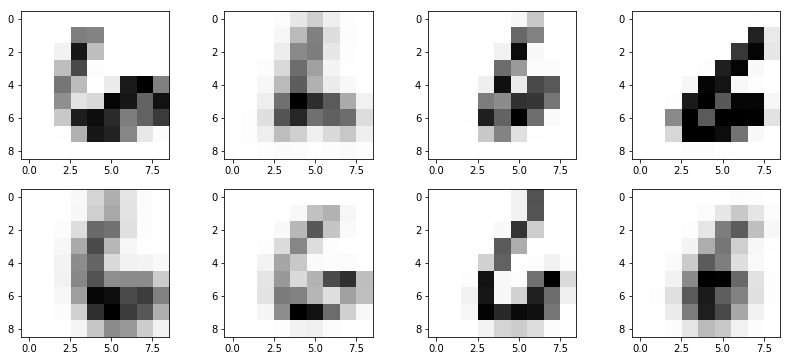

In [19]:
fig, axes = plt.subplots(2, 4, figsize=(14, 6))
for ax in axes.flatten():
    ax.imshow(random.choice(x).reshape(9,9), cmap='Greys')

In [20]:
nb = NaiveBayesClassifier()
nb.train(x, y)

In [21]:
def sample_naive_bayes(nb, digit):
    image = np.empty(len(nb.histograms[digit]))

    for j, hist in enumerate(nb.histograms[digit]):
        r = np.random.random()
        cumhist = np.cumsum(hist.probs)
        l = 0
        while cumhist[l] < r and l < len(cumhist)-1:
            l += 1
        image[j] = np.random.uniform(*hist.bin_edges[l:l+2])
    return image.reshape(9,9)


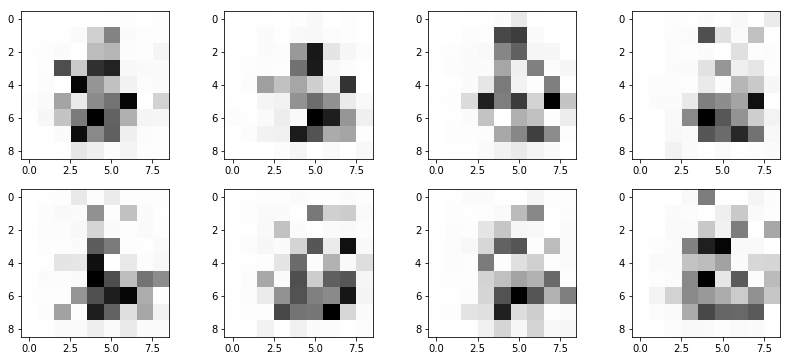

In [22]:
fig, axes = plt.subplots(2, 4, figsize=(14, 6))
for ax in axes.flatten():
    ax.imshow(sample_naive_bayes(nb, digit), cmap='Greys')

# 2. Data Generation & Classification with Density Trees

In [48]:
class DataPass: # empty class which can be accessed by all tree nodes
    pass

class Node:
    def __init__(self, data, bbox, dataobj=None):
        self.__left, self.__right = None, None
        self.data = data
        self.vol = np.product(bbox[:,1]-bbox[:,0])
        
        self.bbox = np.array(bbox)
        
        self.dataobj = dataobj
    
    @property
    def left(self):
        return self.__left
    
    @left.setter
    def left(self, node):
        self.__left = node
        self.__left.dataobj = self.dataobj
        
    @property
    def right(self):
        return self.__left
    
    @right.setter
    def right(self, node):
        self.__right = node
        self.__left.dataobj = self.dataobj
    
    def score(self):
        return - pl**2 * Vl + plam**2 * Vlam + prho**2 * Vrho

def fit_density_tree1(features, tau):
    bincount = int(tau * features.shape[0]**(1/3))

    bbox_root = np.empty((features.shape[1], 2))
    for i in range(features.shape[1]):
        bbox_root[i, 0] = np.min(features[:,i])
        bbox_root[i, 1] = np.max(features[:,i])
    
    
    obj = DataPass() # Data object accessible in all nodes
    obj.Ntot = features.shape[0]
    root = Node(data, bbox_root, dataobj=obj)
    leafs = [(root.score(), root)]
    
    for i in range(bincount-2):
        heapq.
